# NLP From Scratch: Generating Names with a Character-Level RNN

Based on the tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

To ensure the data used in training is selected as in the tutorial, a generator with random sampling based on the category was created. This generator is then utilized by a `DataLoader` with a batch size of 1.

In the original tutorial, training was performed over 100,000 iterations, with data sampled during each iteration. In this example, the training process was modified to run for a specified number of epochs. The number of batches per epoch is determined by the formula `BATCHES = N_ITERS // EPOCHS`. Here, the number of batches corresponds to the number of records trained in each epoch (since the batch size is 1), ensuring that the total number of records used for training remains consistent with the original tutorial.

The datasets from which the dataloaders are created consist of tuples with two elements: the input (used when processing each batch to generate an output) and the target (used with the output to calculate the loss). The input itself is a tuple of two tensors corresponding to the category and text of the record, respectively. The target is the text without the first character, but with an `EOS` character at the end. See the function `transform_to_tensor` for more details.

The custom executor `MyBatchExecutor` handles generating the output for each character of the input, reusing the `hidden` tensor at every step of the iteration until the last output. The output of each step is then concatenated to generate the final output, which should correspond to the target. To maintain batch format, `unsqueeze(0)` is called on this final tensor.

The loss is calculated by first squeezing both the output and the target (each containing only one item) and then iterating over each element of the squeezed tensor, which corresponds to a character, calculating the loss (`NLLLoss`), and summing these values to obtain the total loss for the item.

Additionally, a custom evaluator class (`MyEvaluator`) was created to predict a `tuple[str, str]` input, containing the category and initial letters of names, and to generate and print a name starting with each input letter (equivalent to the `samples` function in the original tutorial).

A custom metrics class was used to calculate and display metrics related to losses, accuracy, and training times, which were then saved to a PDF file (`REPORT_PATH`). You can find implementation examples of various metrics classes in [lib/metrics.py](../lib/metrics.py).

In [1]:
NAME = 'char_rnn_generation'
SAVE_PATH = f'data/test/train/{NAME}-checkpoint.pth'
REPORT_PATH = f'data/test/train/{NAME}-report.pdf'
DATA_PATH = 'data/char_rnn'
RANDOM_SEED = 0

In [2]:
import sys
if "../" not in sys.path:
  sys.path.append("../")

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
import random
import torch
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### Preparing the Data

In [5]:
from auto_mind.supervised.data import SplitData
from src.datasets.names_data import NamesData
from src.lib import data_utils
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def transform(item: tuple[str, int]):
    input, target = item
    input = data_utils.unicode_to_ascii(s=input, allowed_letters=all_letters)
    return input, target

data = NamesData(root_path=DATA_PATH, split_data=SplitData(val_percent=0.2, test_percent=None), random_seed=RANDOM_SEED)
datasets = data.datasets.transform(transform)
all_categories = data.all_labels
n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(data_utils.unicode_to_ascii("O'Néàl", allowed_letters=all_letters))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


### Creating the Network

In [6]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category: torch.Tensor, input: torch.Tensor, hidden: torch.Tensor | None):
        h = hidden if hidden is not None else self.init_hidden()
        input_combined = torch.cat((category, input, h), 1)
        h: torch.Tensor = self.i2h(input_combined)
        output: torch.Tensor = self.i2o(input_combined)
        output_combined = torch.cat((h, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, h

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

### Preparing for Training

In [7]:
# One-hot vector for category
def category_tensor(category_idx: int):
    tensor = torch.zeros(1, n_categories)
    tensor[0][category_idx] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def input_tensor(line: str):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def target_tensor(line: str):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [8]:
from auto_mind.supervised.data import DatasetGroup

def get_letter(letter_idx: int, show_eos=True):
    return ('<eos>' if show_eos else '') if letter_idx == len(all_letters) else all_letters[letter_idx]

def transform_to_tensor(item: tuple[str, int]):
    input, target = item
    cat_tensor = category_tensor(target)
    line_tensor = input_tensor(input)
    tgt_tensor = target_tensor(input)
    return (cat_tensor, line_tensor), tgt_tensor

tensor_datasets: DatasetGroup[tuple[tuple[torch.Tensor, torch.Tensor], torch.LongTensor]] = datasets.transform(transform_to_tensor).sized()

for input, target in iter(tensor_datasets.limit(10).train):
    cat_tensor, line_tensor = input
    category = all_categories[int(cat_tensor[0].argmax(dim=0).item())]
    line = ''.join([get_letter(int(i)) for i in line_tensor[:, 0].argmax(dim=1)])
    target_line = ''.join([get_letter(int(i)) for i in target])
    print(f'category = {category} / line = {line} / target: {target_line}')

category = French / line = Deforest / target: eforest<eos>
category = Italian / line = Alberghini / target: lberghini<eos>
category = Russian / line = Paraskun / target: araskun<eos>
category = English / line = Woodley / target: oodley<eos>
category = Scottish / line = Ritchie / target: itchie<eos>
category = Russian / line = Zhivago / target: hivago<eos>
category = English / line = Ocallaghan / target: callaghan<eos>
category = Italian / line = Ungaretti / target: ngaretti<eos>
category = Russian / line = Viron / target: iron<eos>
category = Japanese / line = Ui / target: i<eos>


In [9]:
import random
from torch.utils.data import DataLoader, Dataset
from auto_mind.supervised.data import IterDataset

def collate_fn(batch: list[tuple[tuple[torch.Tensor, torch.Tensor], torch.LongTensor]]) -> tuple[list[tuple[torch.Tensor, torch.Tensor]], torch.Tensor]:
    inputs, targets = zip(*batch)
    targets = torch.stack(targets)
    return inputs, targets

def get_dataloader(dataset: Dataset[tuple[tuple[torch.Tensor, torch.Tensor], torch.LongTensor]], batch_size: int, amount: int) -> DataLoader:
    def generator():
        items = [i for i in dataset]
        items_per_cat_idx: dict[int, list[tuple[tuple[torch.Tensor, torch.Tensor], torch.LongTensor]]] = {
            i: [] for i in range(n_categories)
        }

        for i in items:
            input, _ = i
            cat_tensor, _ = input
            cat_idx = int(cat_tensor[0].argmax(dim=0).item())
            items_per_cat_idx[int(cat_idx)] += [i]

        for _ in range(amount):
            cat_idx = random.randint(0, n_categories - 1)
            cat_items = items_per_cat_idx[cat_idx]
            idx  = random.randint(0, len(cat_items) - 1)
            yield cat_items[idx]

    return DataLoader(IterDataset(generator), batch_size=batch_size, collate_fn=collate_fn)

def get_train_dataloader(amount: int):
    return get_dataloader(tensor_datasets.train, batch_size=1, amount=amount)

def get_val_dataloader(amount: int):
    assert tensor_datasets.validation is not None
    return get_dataloader(tensor_datasets.validation, batch_size=1, amount=amount)

### Training the Network

In [10]:
import typing

learning_rate = 0.0005

class MyOptimizer(torch.optim.Optimizer):
    def __init__(self, params: typing.Iterator[torch.nn.Parameter], lr: float):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure: typing.Optional[typing.Callable[[], float]] = None): # type: ignore
        loss = None

        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for param_untyped in group['params']:
                p: torch.nn.Parameter = param_untyped
                if p.grad is not None:
                    learning_rate = group['lr']
                    p.data.add_(p.grad.data, alpha=-learning_rate)

        return loss

### Create the Manager

In [11]:
from auto_mind import supervised
from auto_mind.supervised.handlers import Evaluator, BatchAccuracyCalculator, BatchExecutor
from src.lib.metrics import MainMetrics

EPOCHS = 20
N_ITERS = 100000
BATCHES = N_ITERS // EPOCHS
VAL_BATCHES = 1000

rnn = RNN(n_letters, 128, n_letters)

train_dataloader = get_train_dataloader(BATCHES)
validation_dataloader = get_val_dataloader(VAL_BATCHES)

class MyBatchExecutor(BatchExecutor[list[tuple[torch.Tensor, torch.Tensor]], torch.Tensor]):
    def run(self, params) -> torch.Tensor:
        model = params.model
        input_batch: list[tuple[torch.Tensor, torch.Tensor]] = params.input
        assert len(input_batch) == 1
        cat_tensor, line_tensor = input_batch[0]

        output: torch.Tensor | None = None
        hidden: torch.Tensor | None = None
        outputs: list[torch.Tensor] = []

        for i in range(len(line_tensor)):
            output, hidden = model(cat_tensor, line_tensor[i], hidden)
            assert output is not None
            outputs.append(output)

        assert output is not None
        assert hidden is not None

        return torch.cat(outputs).unsqueeze(0)

class MyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.NLLLoss()

    def forward(self, output: torch.Tensor, target: torch.Tensor):
        loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``
        # from (1, n, v) to (n, v), in a list with n elements
        # with v being the number of chars in the vocabulary
        outputs: list[torch.Tensor] = list(output.squeeze(0))
        # from (1, n) to (n, 1)
        target = target.squeeze(0).unsqueeze(-1)

        for i, output in enumerate(outputs):
            # output from (v) to (1, v)
            # i'th element in target (n, 1), give the shape (1)
            # with the value in the target in the range 0..v
            l = self.criterion(output.unsqueeze(0), target[i])
            loss += l

        return loss

class MyAccuracyCalculator(BatchAccuracyCalculator[torch.Tensor, torch.Tensor, torch.Tensor]):
    def run(self, params) -> float:
        output = params.output.squeeze(0)
        target = params.target.squeeze(0)
        accuracy = (output.argmax(dim=1) == target).sum().item() / target.shape[0]
        return accuracy

class MyEvaluator(Evaluator[tuple[str, str], None]):
    def __init__(self, max_length=20):
        self.max_length = max_length

    def run(self, params):
        category, start_letters = params.input
        model = params.model
        self.samples(model=model, category=category, start_letters=start_letters)

    # Get multiple samples from one category and multiple starting letters
    def samples(self, model: torch.nn.Module, category: str, start_letters='ABC'):
        for start_letter in start_letters:
            print(self.sample(model=model, category=category, start_letter=start_letter))

    def sample(self, model: torch.nn.Module, category: str, start_letter='A'):
        max_length = self.max_length
        category_idx = all_categories.index(category)
        cat_tensor = category_tensor(category_idx)
        input = input_tensor(start_letter)

        output_name = start_letter
        hidden: torch.Tensor | None = None
        was_training = model.training
        model.train() # use the dropout layer to increase sampling variety

        for i in range(max_length):
            full_output: tuple[torch.Tensor, torch.Tensor] = model(cat_tensor, input[0], hidden)
            output, hidden = full_output
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = input_tensor(letter)

        model.train(was_training)

        return output_name

manager = supervised.Manager(
    data_params=supervised.ManagerDataParams(
        train_dataloader=train_dataloader,
        validation_dataloader=validation_dataloader,
        test_dataloader=None,
    ),
    model_params=supervised.ManagerModelParams(
        model=rnn,
        criterion=MyLoss(),
        executor=MyBatchExecutor(),
        use_best=False,
    ),
    optimizer_params=supervised.ManagerOptimizerParams(
        optimizer=MyOptimizer(params=rnn.parameters(), lr=learning_rate),
        scheduler=None,
        train_early_stopper=None,
        test_early_stopper=None,
    ),
    metrics_params=supervised.ManagerMetricsParams(
        evaluator=MyEvaluator(),
        accuracy_calculator=MyAccuracyCalculator(),
        metrics_calculator=MainMetrics(name=NAME).as_file_plotter(file_path=REPORT_PATH, figsize=(8, 8)),
        batch_interval=False,
        default_interval=1,
    ),
    config=supervised.ManagerConfig(
        save_path=SAVE_PATH,
        random_seed=RANDOM_SEED,
        train_hook=None,
    ),
)

Starting training for 20 epochs...
[end of epoch  1 (  5.0%)] [time:   0m 31.23s (eta:   9m 53.45s)] [val_accuracy:  22.7%, train_accuracy:  19.9%] [val_loss: 17.9284, train_loss: 20.5927]
[end of epoch  2 ( 10.0%)] [time:    1m 0.55s (eta:    9m 4.98s)] [val_accuracy:  25.3%, train_accuracy:  23.4%] [val_loss: 17.1126, train_loss: 18.0951]
[end of epoch  3 ( 15.0%)] [time:   1m 35.83s (eta:    9m 3.04s)] [val_accuracy:  28.0%, train_accuracy:  26.6%] [val_loss: 16.1502, train_loss: 17.4113]
[end of epoch  4 ( 20.0%)] [time:    2m 5.24s (eta:   8m 20.95s)] [val_accuracy:  28.9%, train_accuracy:  27.9%] [val_loss: 15.9080, train_loss: 17.0341]
[end of epoch  5 ( 25.0%)] [time:   2m 40.05s (eta:    8m 0.15s)] [val_accuracy:  29.1%, train_accuracy:  28.5%] [val_loss: 15.7190, train_loss: 16.7363]
[end of epoch  6 ( 30.0%)] [time:   3m 12.44s (eta:   7m 29.03s)] [val_accuracy:  30.0%, train_accuracy:  29.0%] [val_loss: 15.3483, train_loss: 16.4764]
[end of epoch  7 ( 35.0%)] [time:   3m 34

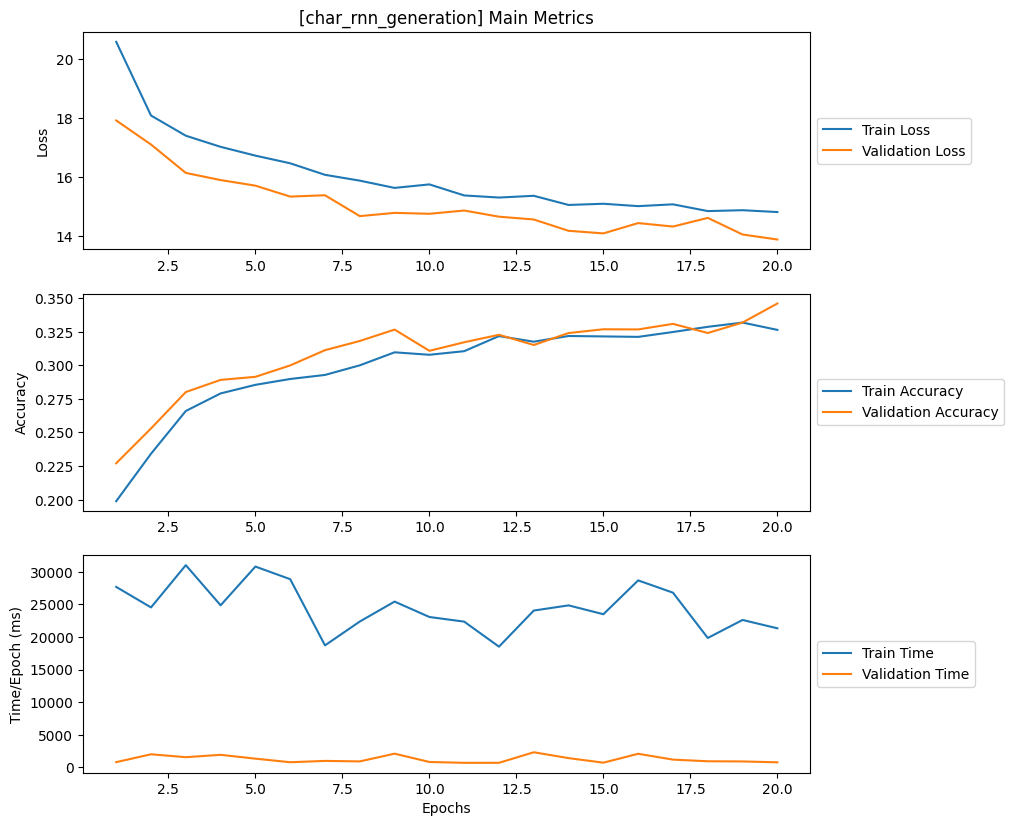

In [12]:
manager.train(epochs=EPOCHS)

In [13]:
manager.evaluate(('Russian', 'RUS'))
manager.evaluate(('German', 'GER'))
manager.evaluate(('Spanish', 'SPA'))
manager.evaluate(('Chinese', 'CHI'))

Rovakov
Uarthov
Sharov
Grang
Eren
Roure
Santer
Parez
Artan
Can
Han
Iha
